In [1]:
# Import packages
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
import seaborn as sns

# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

# Load and Merge Datasets
In this section we will load the *video game global sales* dataset, and the *video games developer base country* dataset. We will then merge the two datasets to create a single dataset that contains all the information we need to answer the questions we have.

In [23]:
# Import dataset
data_file_path = "datasets/video-game-sales.csv"
companie_region_path = "datasets/video-games-developers.csv"

# Load the data
df = pd.read_csv(data_file_path)
df_companies = pd.read_csv(companie_region_path)

# Merge the two datasets
df = pd.merge(df, df_companies[['Developer', 'Country']], left_on='Publisher', right_on='Developer', how='left')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer,Country
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo,Japan
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Nintendo,Japan
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo,Japan
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo,Japan
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,Nintendo,Japan


# Released Games by Year
This section aims to analysis the number of games released by year. The dataset contains information about games released from 1980 to 2020. We will use this information to create a bar plot that shows the number of games released by year.

### The total realised games by year

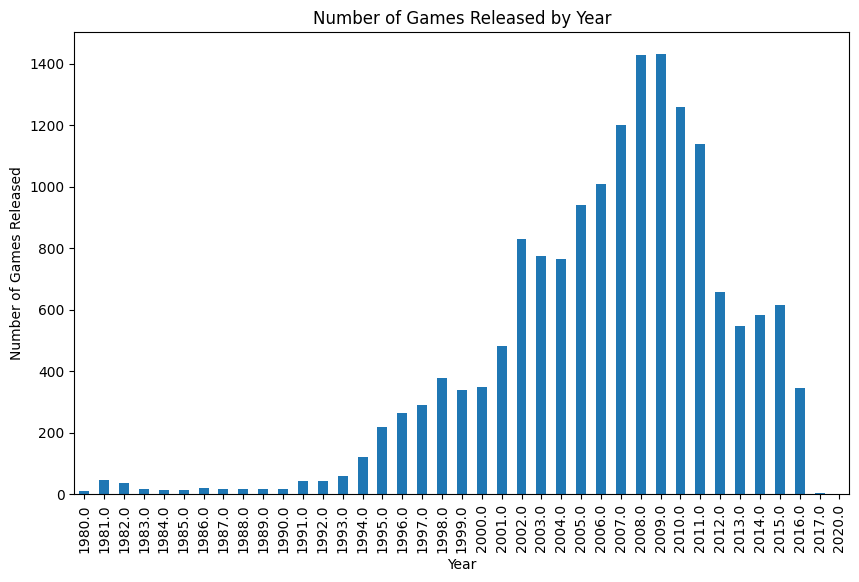

In [24]:
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.title('Number of Games Released by Year')
plt.show()

### The total releasd games by platform

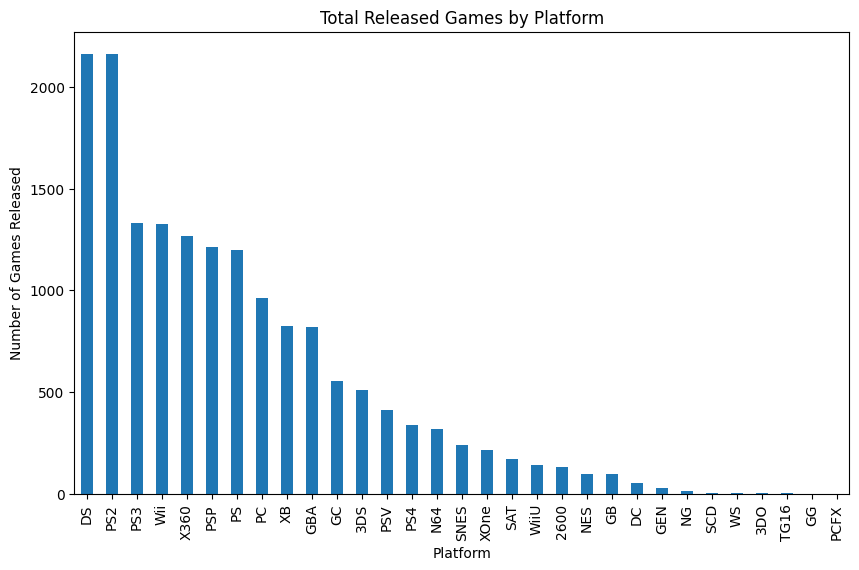

In [25]:
total_released_games_by_platform = df['Platform'].value_counts()
total_released_games_by_platform.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Platform')
plt.ylabel('Number of Games Released')
plt.title('Total Released Games by Platform')
plt.show()

### The Top-selling Game of Each Year
This code snippet is designed to visualize the total video game sales of each year, and contains the top-selling game of each specific year.

In [26]:
# Get the top game in each year
top_games = df.sort_values('Global_Sales', ascending=False).drop_duplicates(['Year'])

# Create the plot
fig = px.bar(top_games, x='Year', y='Global_Sales', color='Year', text='Name', 
             labels={'Year': 'Year', 'Global_Sales': 'Total Sales', 'Name': 'Top Game'}, 
             title='Top Game in Each Year')

fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

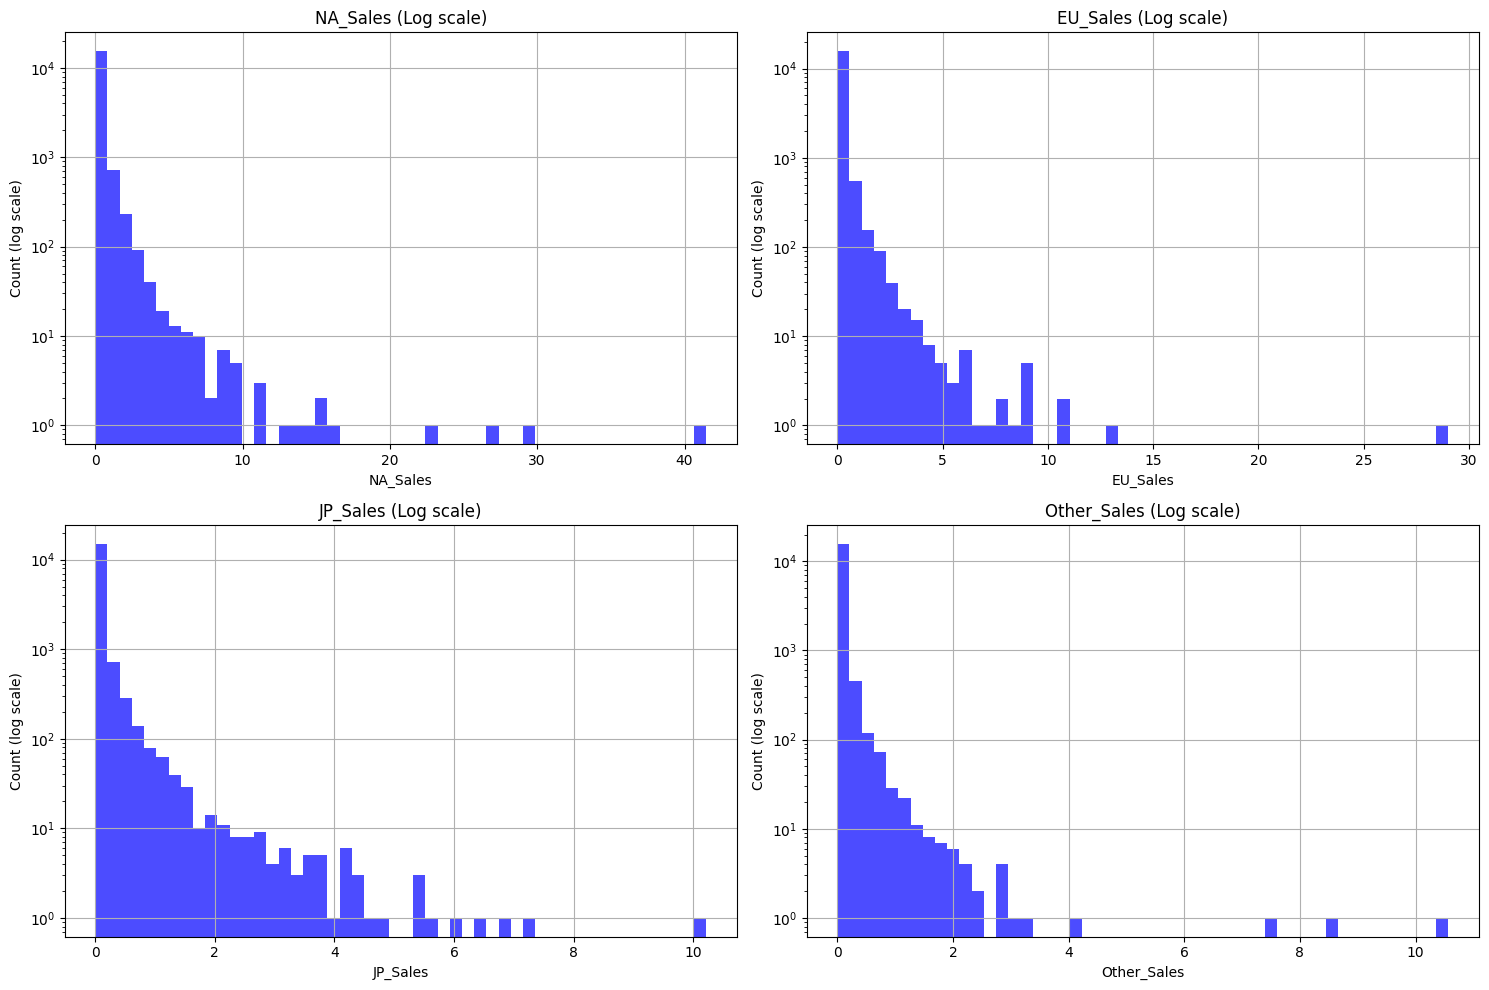

In [27]:
# Function to plot histograms with log scale
def plot_log_histograms(df, columns, bins=50):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the array for easy iteration
    
    for i, column in enumerate(columns):
        # Plot with a log scale for the y-axis to better visualize the distribution
        axes[i].hist(df[column], bins=bins, color='blue', alpha=0.7)
        axes[i].set_title(f'{column} (Log scale)')
        axes[i].set_yscale('log')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Count (log scale)')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Columns to plot
columns_to_plot = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# Plot the histograms
plot_log_histograms(df, columns_to_plot)

# Sales Distribution

### Most Popular Video Game Producers by Country
The following code snippet is designed to create a grid of horizontal bar charts, depicting the top-selling video game publishers for different regions (North America, Europe, Japan, and Other Regions) and globally.

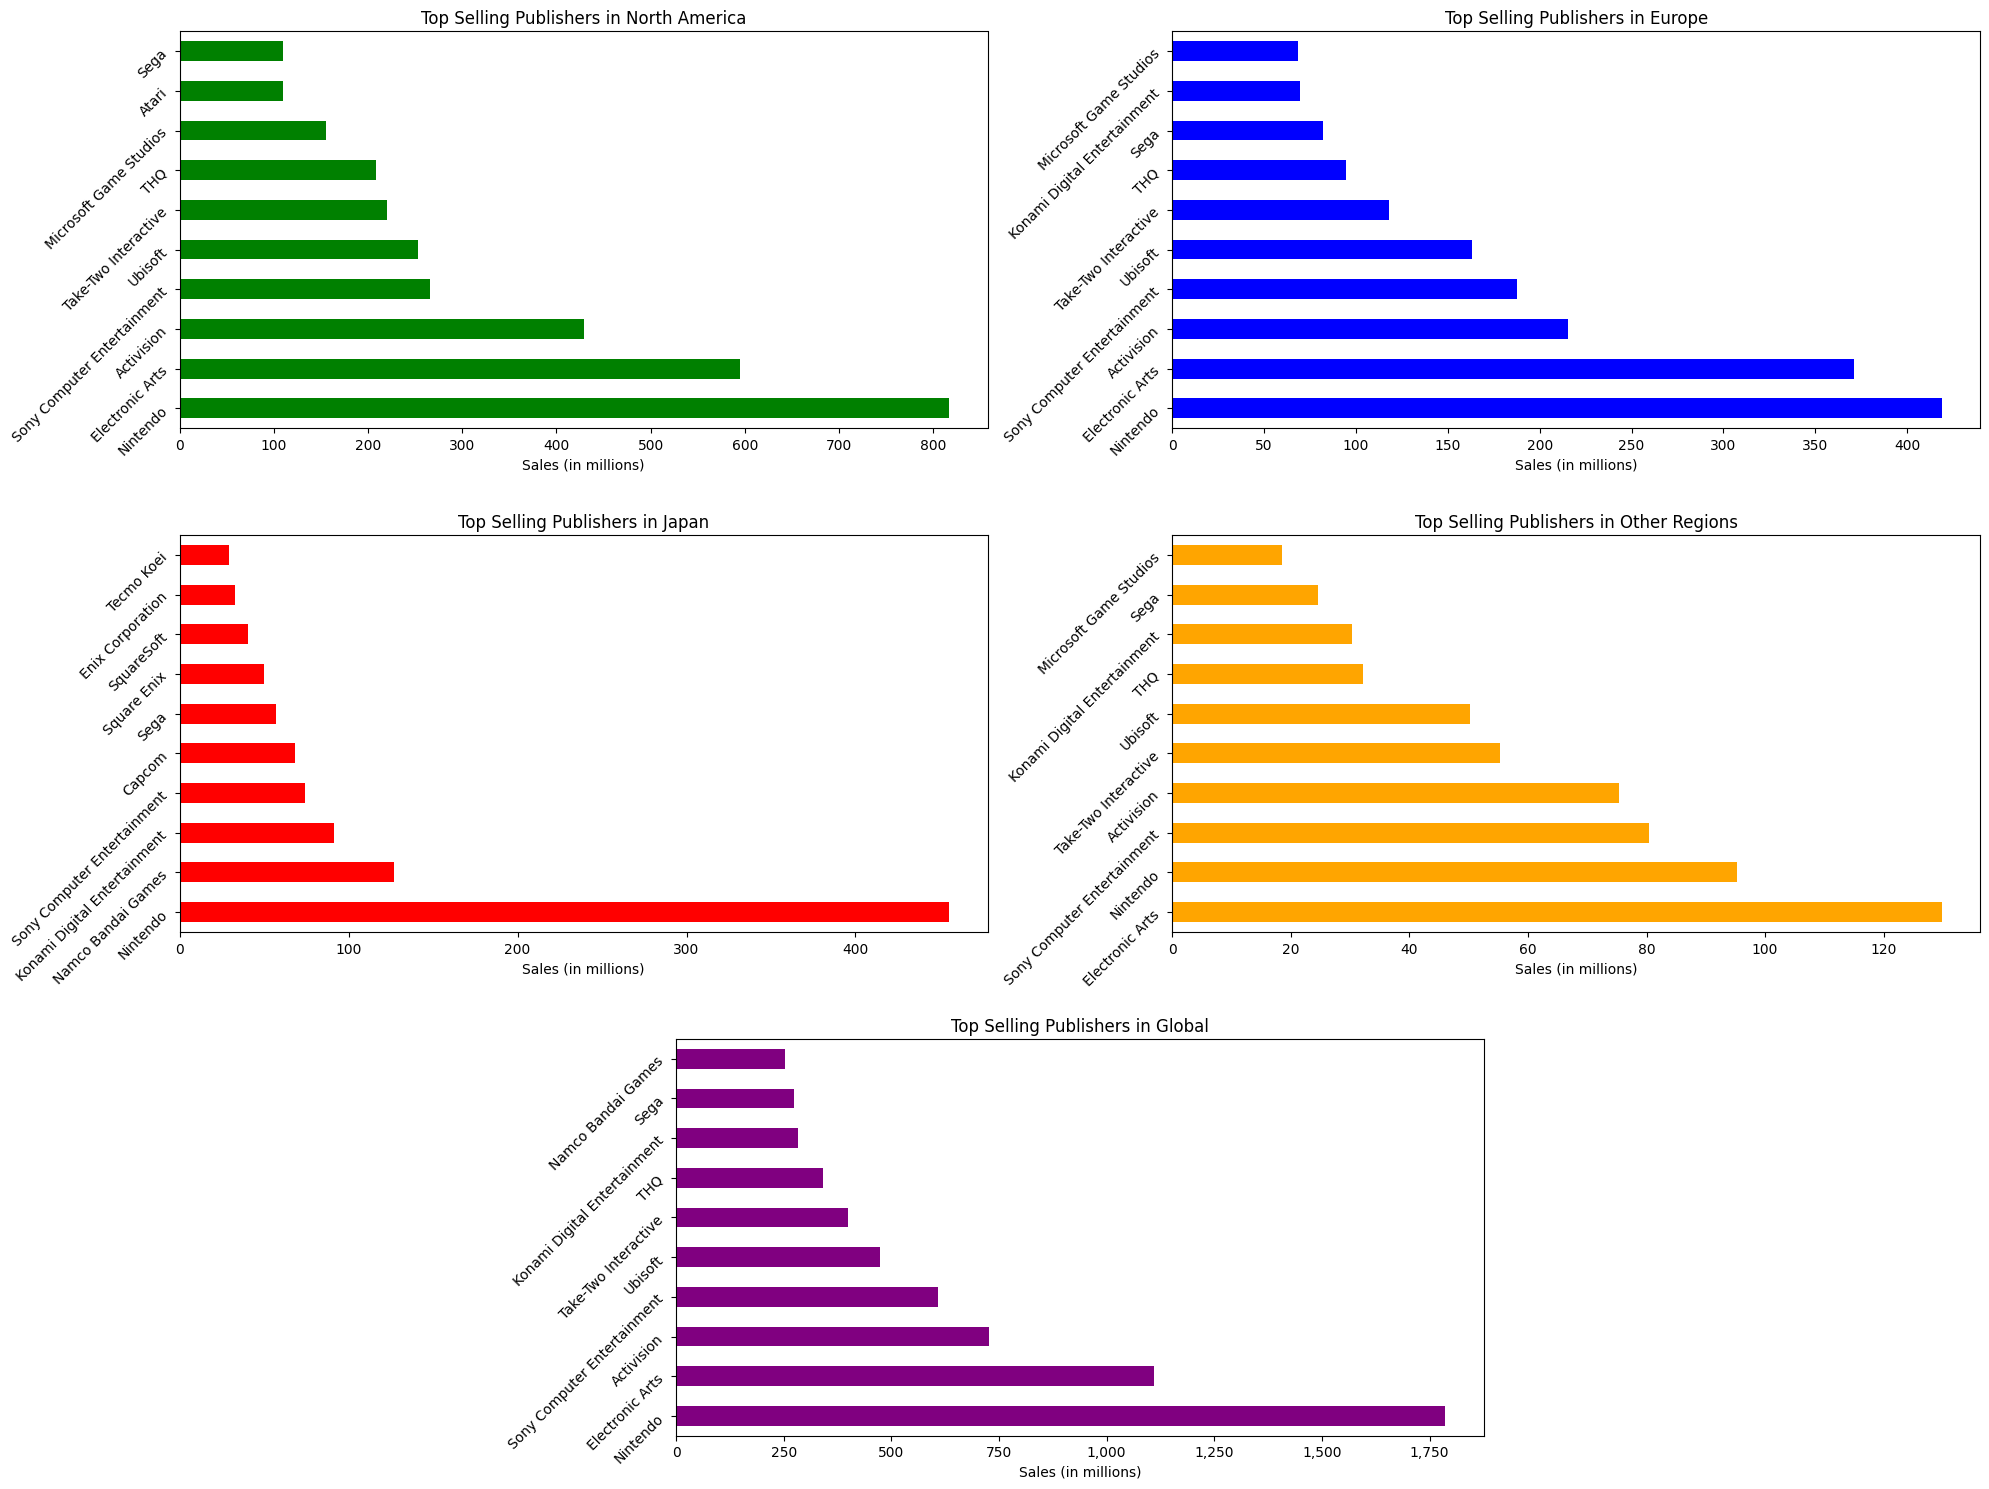

In [28]:
import matplotlib.ticker as mticker

# Group by publisher and platform to get the total sales in each region
sales_by_publisher_region = df.groupby(['Publisher', 'Platform']).agg({
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Other_Sales': 'sum',
    'Global_Sales': 'sum'
}).reset_index()

def create_bar_charts(data, region_columns, region_titles, colors, n_top_publishers=10):
    # Adjust the size of the entire figure to give more space for the labels
    plt.figure(figsize=(20, 15))

    # Setup the axes for the grid of bar charts
    ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
    ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=2)
    ax4 = plt.subplot2grid((3, 4), (1, 2), colspan=2)
    ax5 = plt.subplot2grid((3, 4), (2, 1), colspan=2)  # Global sales in the middle
    
    axes = [ax1, ax2, ax3, ax4, ax5]

    # Plot each region's top publishers
    for i, region in enumerate(region_columns):
        ax = axes[i]
        # Only get the top N publishers for each region to reduce clutter
        top_publishers = data.groupby('Publisher')[region].sum().sort_values(ascending=False).head(n_top_publishers)
        top_publishers.plot(kind='barh', color=colors[i], ax=ax)
        
        ax.set_title(f'Top Selling Publishers in {region_titles[i]}')
        ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_xlabel('Sales (in millions)')
        ax.set_ylabel('')

        for label in ax.get_yticklabels():
            label.set_rotation(45)
            label.set_ha('right')

    plt.tight_layout()  
    plt.show()

region_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
region_names = ['North America', 'Europe', 'Japan', 'Other Regions', 'Global']
chart_colors = ['green', 'blue', 'red', 'orange', 'purple']

create_bar_charts(sales_by_publisher_region, region_cols, region_names, chart_colors, n_top_publishers=10)

### Global Sales by Platform and Genre
This code snippet creates a heatmap that shows the total global sales of video games by platform and genre. This visualization helps us understand the game genres preference of the top 10 popular platforms.

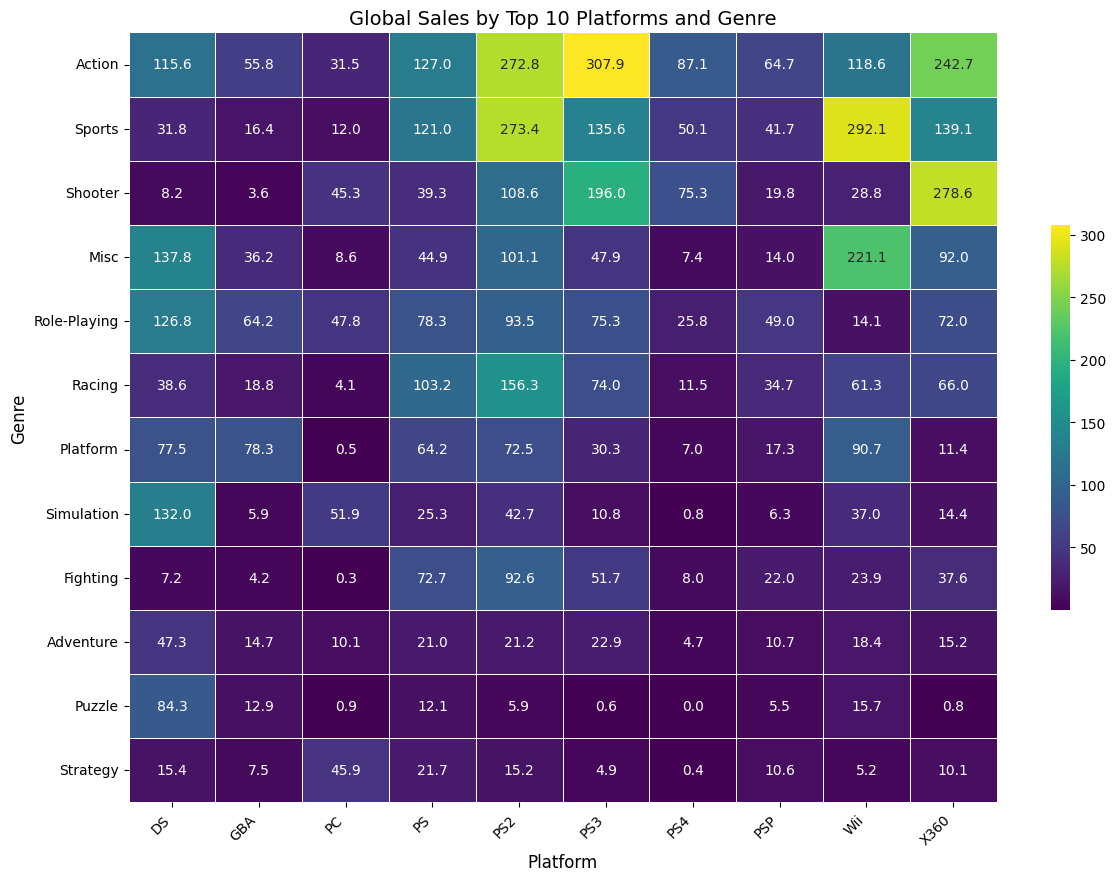

In [29]:
# Aaggregate global sales by genre and platform
platform_sales = df.groupby(['Platform', 'Genre'])['Global_Sales'].sum().reset_index()

# Identify the top 10 platforms based on total global sales
top_platforms = platform_sales.groupby('Platform')['Global_Sales'].sum().nlargest(10).index

# Filter the original data for only the top 10 platforms
top_platform_sales = platform_sales[platform_sales['Platform'].isin(top_platforms)]

# Create the pivot table for the filtered data
pivot = top_platform_sales.pivot_table(index='Genre', columns='Platform', values='Global_Sales', aggfunc='sum')

# Sort genres by their total sales across all top platforms
pivot['Total_Sales'] = pivot.sum(axis=1)
pivot_sorted = pivot.sort_values('Total_Sales', ascending=False).drop('Total_Sales', axis=1)

# Generate the heatmap
plt.figure(figsize=(14, 10))  # Adjust the figure size to fit the top 10 platforms
cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(pivot_sorted, cmap=cmap, linewidths=.5, annot=True, fmt=".1f", cbar_kws={'shrink': .5},
            annot_kws={"size": 10})

plt.xticks(rotation=45, ha='right', size=10)
plt.yticks(size=10)
plt.title('Global Sales by Top 10 Platforms and Genre', size=14)
plt.xlabel('Platform', size=12)
plt.ylabel('Genre', size=12)

plt.show()

### Sales Distribution by Genre and Region
This code snippet creates a heatmap that shows the total sales of video games by genre and region. The picture intuitively show which genres are the most popular across different regions.

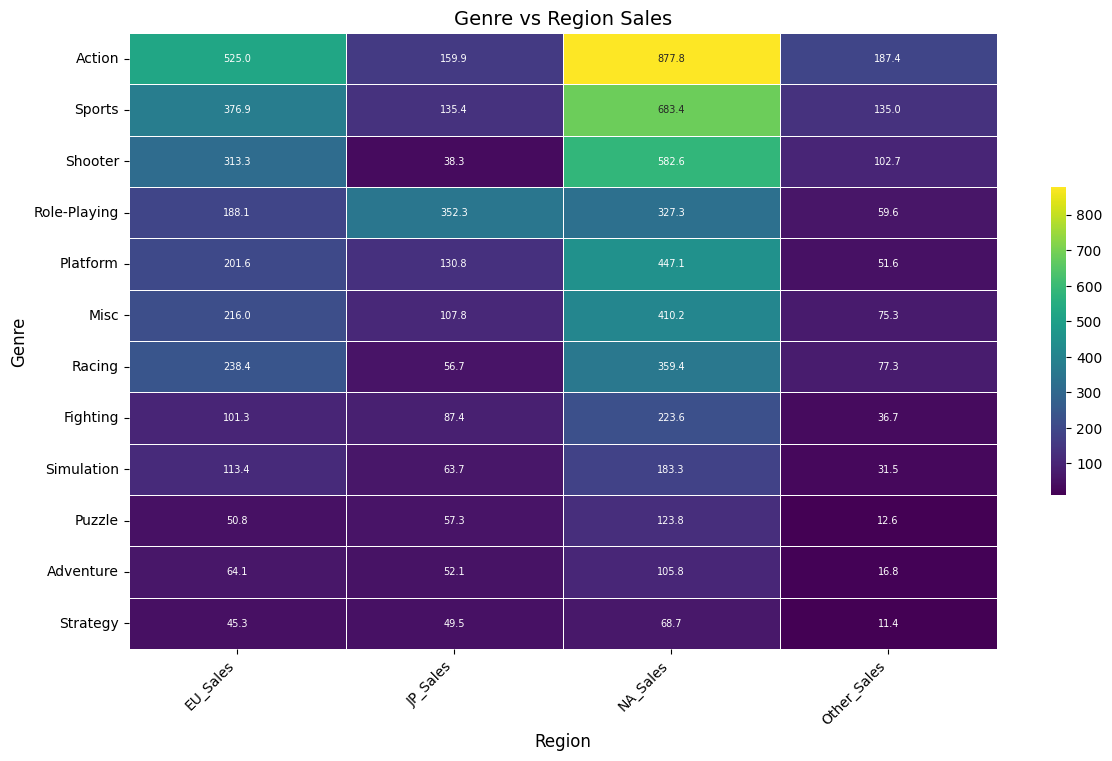

In [30]:
# Create the pivot table
pivot = df.pivot_table(index='Genre', values=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], aggfunc='sum')

# Calculate the total sales for each genre
pivot['Total_Sales'] = pivot.sum(axis=1)

# Sort the genres by total sales in descending order
pivot_sorted = pivot.sort_values('Total_Sales', ascending=False).drop('Total_Sales', axis=1)

# Create the heatmap
plt.figure(figsize=(14, 8))
cmap = sns.color_palette("viridis", as_cmap=True)
sns.heatmap(pivot_sorted, cmap=cmap, linewidths=.5, annot=True, fmt=".1f", cbar_kws={'shrink': .5},
            annot_kws={"size": 7})

plt.xticks(rotation=45, ha='right', size=10)
plt.yticks(size=10)
plt.title('Genre vs Region Sales', size=14)
plt.xlabel('Region', size=12)
plt.ylabel('Genre', size=12)

plt.show()

# Publisher Analysis
This section aims to analyze the information related to publishers in the video game industry.

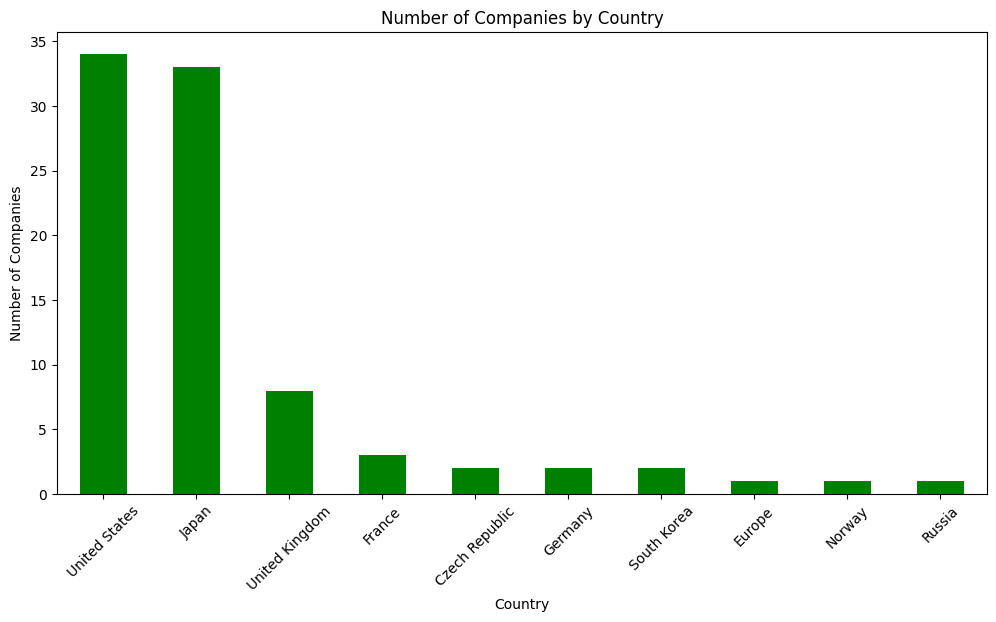

In [34]:
# Group by country and count the number of companies
companies_by_country = df.groupby('Country')['Publisher'].nunique().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
companies_by_country.plot(kind='bar', color='green')

# Set the title and labels
plt.title('Number of Companies by Country')
plt.xlabel('Country')
plt.ylabel('Number of Companies')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Load Another Dataset
Besides the *video game global sales* dataset, and the *video games developer base country* dataset. We will also analyze another dataset called *video games popularity* as the supplement.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.processing import clean_column_names, convert_str_num_to_int

In [11]:
# loading the dataset
df = pd.read_csv("datasets/video-games-popularity.csv")
# drop the first column as it is not needed
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


In [12]:
# Printing the number of duplicate values
dup_count = df.duplicated().sum()

print(f"There are {dup_count} duplicate values in the dataset")

There are 382 duplicate values in the dataset


In [13]:
# Printing the number of null values
null_count = df.isnull().sum()

print(f"There are {null_count.sum()} null values in the dataset")

There are 15 null values in the dataset


In [14]:
# Filtering out rows that includes NUll values 
df = df.dropna()

print(f"There are {df.isnull().sum().sum()} null values now in the dataset")

There are 0 null values now in the dataset


**stage1: clean the dataset**

In [15]:
# Release Date column has some values that are not dates, we need to drop them
cond = df["Release Date"] == "releases on TBD"
df = df[~cond]

In [16]:
# Changing the columns name to lower case and replacing spaces with '_' for consistency.
df = clean_column_names(df)

df.head()

,title,release_date,team,rating,times_listed,number_of_reviews,genres,summary,reviews,plays,playing,backlogs,wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


In [17]:
# Change the string data type (K) to integer (times 1000) for some columns
candidate_columns = ['times_listed', 'number_of_reviews', 'plays', 'playing', 'backlogs', 'wishlist']

df = convert_str_num_to_int(df, candidate_columns)
df.head()

,title,release_date,team,rating,times_listed,number_of_reviews,genres,summary,reviews,plays,playing,backlogs,wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3900,3900,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17000,3800,4600,4800
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2900,2900,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21000,3200,6300,3600
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4300,4300,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30000,2500,5000,2600
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3500,3500,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28000,679,4900,1800
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3000,3000,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21000,2400,8300,2300


**stage2: basic EDA**

C:\Users\nec\AppData\Local\Temp\ipykernel_9744\1203802662.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




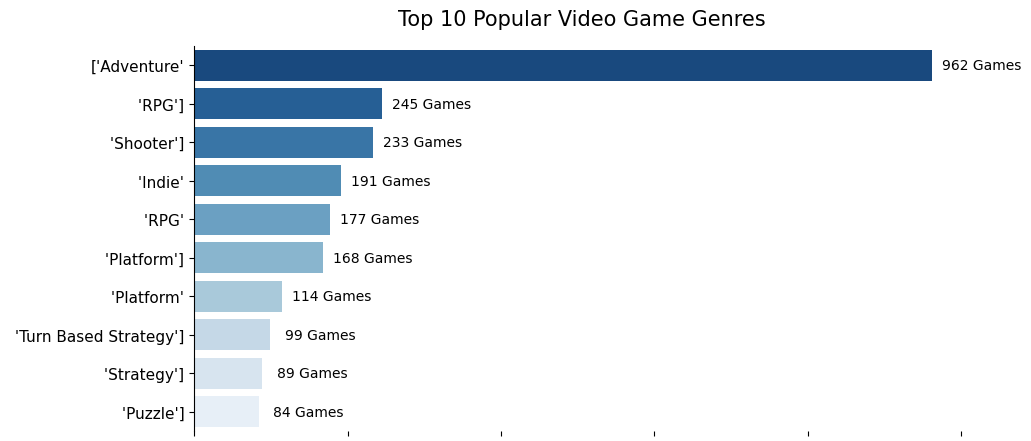

In [18]:
# plot the Top 10 most popular video games genres by number of this kind of games

# compute the number of games in each genre
df["genres"] = df["genres"].str.replace('[\[\]\'\"]', "")
genres = df["genres"].str.get_dummies(",")
popularity = genres.sum().sort_values(ascending=False)

# plot the bar chart
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=popularity[:10].values, y=popularity[:10].index, palette="Blues_r", ax=ax)

for i, v in enumerate(popularity[:10].values):
    ax.text(v + 130 / 2, i, str(f"{v} Games"), color="black", ha="center", va="center")

ax.set_title("Top 10 Popular Video Game Genres", fontsize=15, pad=15)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.tick_params(axis="y", labelsize=11)
sns.despine(right=True, top=True, bottom=True)
plt.show()

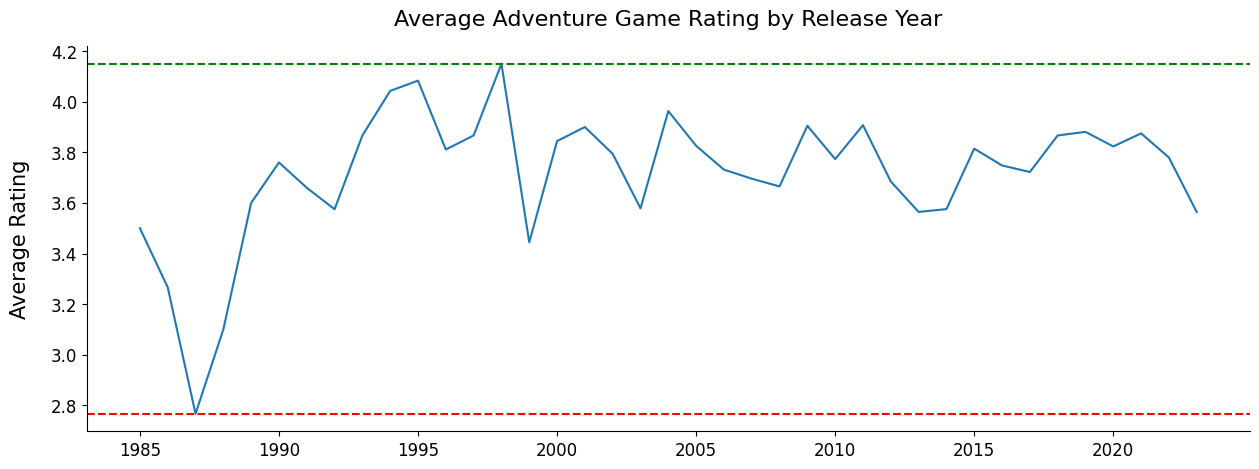

In [19]:
# plot the trends of the average Adventure video games'rating over the years

adventure_games_df = df[df["genres"].str.contains("Adventure")]
adventure_games_df["release_date"] = pd.to_datetime(adventure_games_df["release_date"])
adventure_games_df["release_year"] = adventure_games_df["release_date"].dt.year
yearly_avg_rating = adventure_games_df.groupby("release_year")["rating"].mean().reset_index()

plt.figure(figsize=(15, 5))
sns.lineplot(data=yearly_avg_rating, x="release_year", y="rating")

sns.despine(top=True, right=True)
plt.title("Average Adventure Game Rating by Release Year", fontsize=16, pad=15)
plt.xlabel("")
plt.ylabel("Average Rating", labelpad=15, fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=yearly_avg_rating["rating"].max(), color="green", linestyle="--")
plt.axhline(y=yearly_avg_rating["rating"].min(), color="red", linestyle="--")
plt.show()
